# 2020/10/16
## IBIS2020 Variable Importance Cloudの要約方法と決定木に対する実験的評価

In [1]:
import numpy as np
from sklearn import datasets
from sklearn import __version__ as sklearn_version
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus as pdp
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from sklearn.metrics import mean_squared_error
%matplotlib inline

## 関数 rf_
- input :
    - X : input data
    - y : output data
    - restrict : what restrict tree depth or leaf
    - num :  number of depth or leaf
    - estimators : number of trees to construct models
    - random : number of random seed

In [2]:
def rf_(X, y, restrict, num, estimators, random):
    
    if restrict == "depth":
        rf = RandomForestClassifier(n_estimators = estimators, max_depth = num, max_features=1,
                               random_state=random)
    elif restrict == "leaf":
        rf = RandomForestClassifier(n_estimators = estimators, max_leaf_nodes = num, max_features=1,
                               random_state=random)
    else:
        print("please input restrict tree by depth or leaf")
    
    rf.fit(X, y)
    
    #空のリストを作成し決定木を追加する
    DT_list = []
    
    for i in range(estimators):
        estimator = rf.estimators_[i]
        DT_list.append(estimator)
            
    return DT_list

## 関数 et_
- input :
    - X : input data
    - y : output data
    - restrict : what restrict tree depth or leaf
    - num :  number of depth or leaf
    - estimators : number of trees to construct models
    - random : number of random seed

In [3]:
def et_(X, y, restrict, num, estimators, random):
    
    if restrict == "depth":
        et = ExtraTreesClassifier(n_estimators = estimators, max_depth = num, max_features=1,
                               random_state=random)
    elif restrict == "leaf":
        et = ExtraTreesClassifier(n_estimators = estimators, max_leaf_nodes = num, max_features=1,
                               random_state=random)
    else:
        print("please input restrict tree by depth or leaf")
    
    et.fit(X, y)
    
    #空のリストを作成し決定木を追加する
    DT_list = []
    
    for i in range(estimators):
        estimator = et.estimators_[i]
        DT_list.append(estimator)
            
    return DT_list

## 関数 rashomon_set
- input : 
    * X : input data
    * y : output data
    * DT_list : list of decision tree
    * num : number of candidate of rashomon set
- output : 
    * candidate of rashomon set

In [4]:
def rashomon_set(X, y, DT_list, num):
    
    score_list = [] #決定木のスコアのリスト
    rashomon = []
        
    for i in range(len(DT_list)):
        DT = DT_list[i]
        #label = y
        #pred = DT.predict(X)
        #score = np.sqrt(mean_squared_error(label, pred))
        score = 1 - DT.score(X, y)
        #print(i, score)
        if i < num:
            rashomon.append(DT)
            score_list.append(score)
        else:
            if score < max(score_list):
                point = score_list.index(max(score_list))
                rashomon[point] = DT
                score_list[point] = score
    
    return rashomon, score_list

## 関数 VIC
 - input :
     - X : input data
     - y : output data
     - rashomon : rashomon set
     - method : method of compute feature importance
 - output :
     - VIC

In [5]:
def VIC(X, y, rashomon, method):
    
    fi = []
    if method == "gain":
        for i in range(len(rashomon)): fi.append(rashomon[i].feature_importances_)
    elif method == "per":
        for i in range(len(rashomon)):
            result = permutation_importance(rashomon[i], X, y, n_repeats=5, random_state=0)
            per_fi = result.importances_mean/sum(result.importances_mean)
            fi.append(per_fi)
            #print(sum(per_fi))
    else:
        print("please input method of compute feature importance")
        print("gain => gain or permutation importance => per")
        
    return fi

## 関数 VIC_scatter
- input : 
    - VIC : VIC list 

In [63]:
def VIC_scatter(VIC, imp):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
     
    # 箱ひげ図
    fig, ax = plt.subplots()
    bp = ax.boxplot(fi_list)
    ax.set_xticklabels(label)
    # タイトル名
    plt.title("box plot of {} importance for monk1 dataset before one hot encoding".format(imp))
    # ラベル名
    plt.xlabel("feature")
    plt.ylabel("feature importance")
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)
    
    #corr = df.corr()
    #sns.heatmap(corr)
    #plt.title("heat map of correlation coefficients of {} importance for monk1 dataset before one hot encoding".format(imp))
    
    sns.catplot(data=df, kind='swarm')
    plt.title("swarm plot of {} importance for monk1 dataset by random".format(imp))
    """
    #sns.pairplot(df, corner=True)
    g = sns.pairplot(df)
    g = g.map_upper(plt.scatter)
    g = g.map_lower(sns.kdeplot, cmap='hot', shade=True)
    g = g.map_diag(plt.hist)
    plt.subplots_adjust(top=0.9)
    g = g.fig.suptitle("pair plot of {} importance for monk1 dataset before one hot encoding".format(imp),
                      y=0.95, size=24)
    """

## 関数 VIC_correlation
- input : 
    - VIC : VIC list 

In [65]:
def VIC_correlation(VIC, imp):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)
    
    corr = df.corr()
    sns.heatmap(corr, square=True, annot=True, cmap='hot')
    plt.title("heat map of correlation coefficients of {} importance for monk1 dataset before one hot encoding".format(imp))
    
    g = sns.pairplot(df)
    g = g.map_upper(plt.scatter)
    g = g.map_lower(sns.kdeplot, cmap='hot', shade=True)
    g = g.map_diag(plt.hist)
    plt.subplots_adjust(top=0.9)
    g = g.fig.suptitle("pair plot of {} importance for monk1 dataset by random".format(imp),
                      y=0.95, size=24)

## experimet for monk1

In [8]:
monk_data1 = pd.read_table('data/monk1/monks-1.train', header=None, sep=' ')
monk_train = monk_data1.drop([0, 8], axis=1)

monk_data2 = pd.read_table('data/monk1/monks-1.test', header=None, sep=' ')
monk_test = monk_data2.drop([0, 8], axis=1)

monk_all = pd.concat([monk_train, monk_test])
monk_all.head()

,1,2,3,4,5,6,7
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [9]:
X_monk = monk_all.drop(1, axis=1)
print(X_monk.head())
print("-" * 50)
y_monk = monk_all[1]
y_monk.head()
print(y_monk.head())
X_train, X_test, y_train, y_test = train_test_split(X_monk, y_monk, test_size = 0.3, random_state = 0)

   2  3  4  5  6  7
0  1  1  1  1  3  1
1  1  1  1  1  3  2
2  1  1  1  3  2  1
3  1  1  1  3  3  2
4  1  1  2  1  2  1
--------------------------------------------------
0    1
1    1
2    1
3    1
4    1
Name: 1, dtype: int64


In [58]:
rt_dt_list = rf_(X_train, y_train, "depth", 3, 1000, 0)
et_dt_list = et_(X_train, y_train, "depth", 3, 1000, 0)
dt_list = rt_dt_list + et_dt_list

In [59]:
rashomon_list, score_list = rashomon_set(X_test, y_test, dt_list, 100)

In [26]:
base_dt = DecisionTreeClassifier(max_depth=3, random_state=0)
base_dt.fit(X_train, y_train)
base_score = 1 - base_dt.score(X_test, y_test)
print("base_score : " + str(base_score))
print("max score : " + str(max(score_list)))
print("epsilon : " + str(max(score_list)/base_score))

base_score : 0.16766467065868262
max score : 0.20958083832335328
epsilon : 1.25


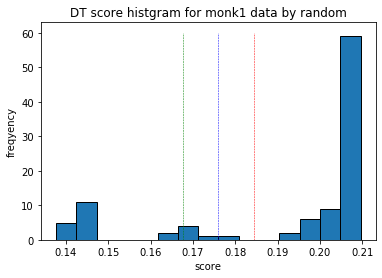

In [31]:
hist, bin_edges = np.histogram(score_list, bins=20)
plt.title('DT score histgram for monk1 data by random')
plt.xlabel('score')
plt.ylabel('freqyency')
plt.hist(score_list, bins=15, histtype='barstacked', ec='black')

plt.vlines(base_score, 0, 60, "green", linestyle='dashed', linewidth=0.5)
# ε=1.05 に赤い線
plt.vlines(base_score*1.05, 0, 60, "blue", linestyle='dashed', linewidth=0.5)
# ε=1.1 に青い線
plt.vlines(base_score*1.1, 0, 60, "red", linestyle='dashed', linewidth=0.5)

In [38]:
vic_list = VIC(X_train, y_train, rashomon_list, "gain")

df = pd.DataFrame(vic_list)

df_0 = pd.DataFrame(index=df.index, columns=[])
df_0["feature"] = ["X0"]*200
df_0["feature importance"] = df[0]

df_1 = pd.DataFrame(index=df.index, columns=[])
df_1["feature"] = ["X1"]*200
df_1["feature importance"] = df[1]
df_fi = pd.concat([df_0, df_1])
#print(df_fi.head())
df_2 = pd.DataFrame(index=df.index, columns=[])
df_2["feature"] = ["X2"]*200
df_2["feature importance"] = df[2]
df_fi = pd.concat([df_fi, df_2], axis=0)

df_3 = pd.DataFrame(index=df.index, columns=[])
df_3["feature"] = ["X3"]*200
df_3["feature importance"] = df[3]
df_fi = pd.concat([df_fi, df_3], axis=0)
#print(df_fi.head())
df_4 = pd.DataFrame(index=df.index, columns=[])
df_4["feature"] = ["X4"]*200
df_4["feature importance"] = df[4]
df_fi = pd.concat([df_fi, df_4], axis=0)

df_5 = pd.DataFrame(index=df.index, columns=[])
df_5["feature"] = ["X5"]*200
df_5["feature importance"] = df[5]
df_fi = pd.concat([df_fi, df_5], axis=0)
#print(df_fi.head())

df_fi.head()

sns.violinplot(x="feature", y="feature importance", data=df_fi)

df = pd.DataFrame(vic_list)
sns.violinplot(data=df)
sns.catplot(data=df, kind='swarm')
plt.show()

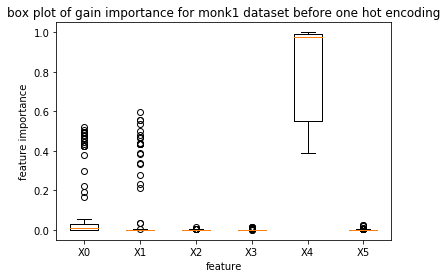

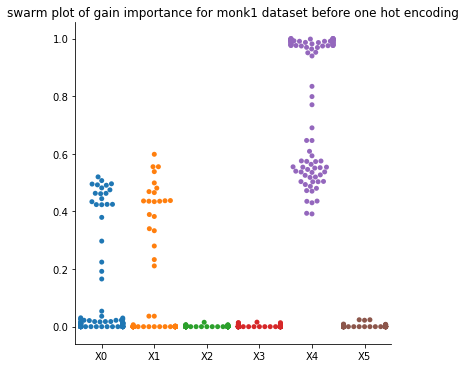

In [33]:
VIC_scatter(vic_list, "gain")

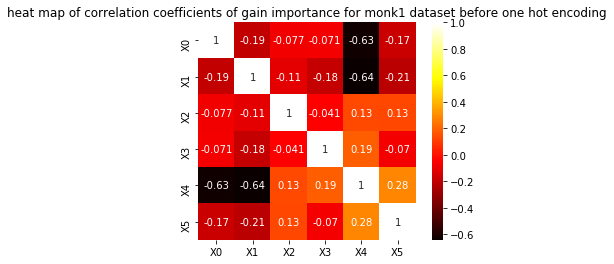

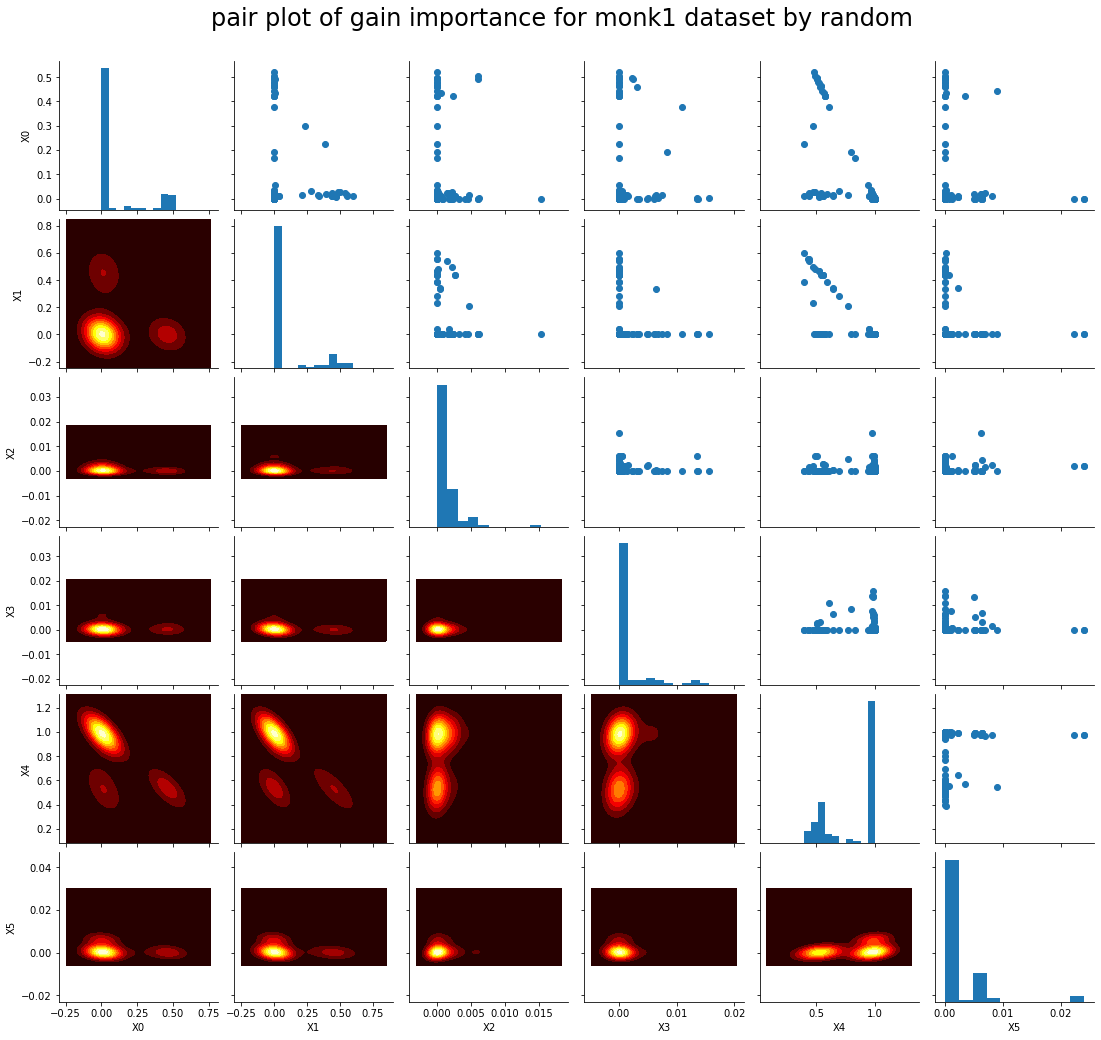

In [66]:
VIC_correlation(vic_list, "gain")

In [60]:
vic_list2 = VIC(X_test, y_test, rashomon_list, "per")

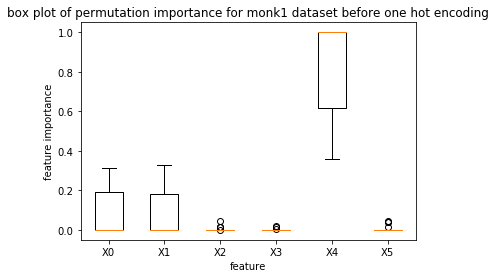

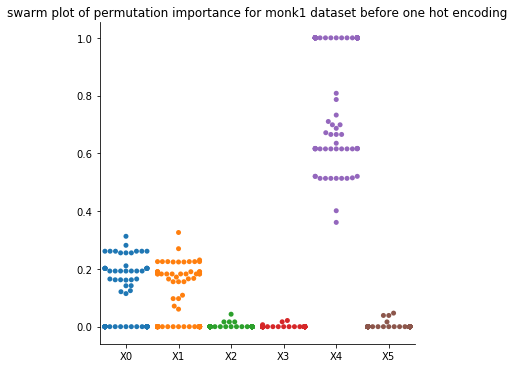

In [61]:
VIC_scatter(vic_list2, "permutation")

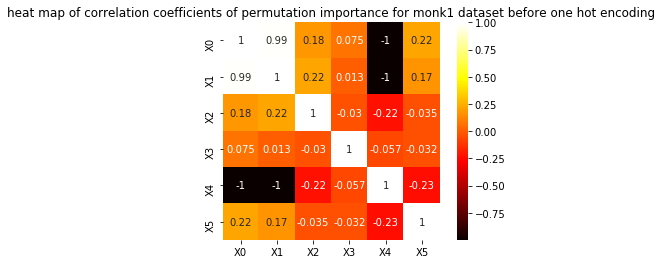

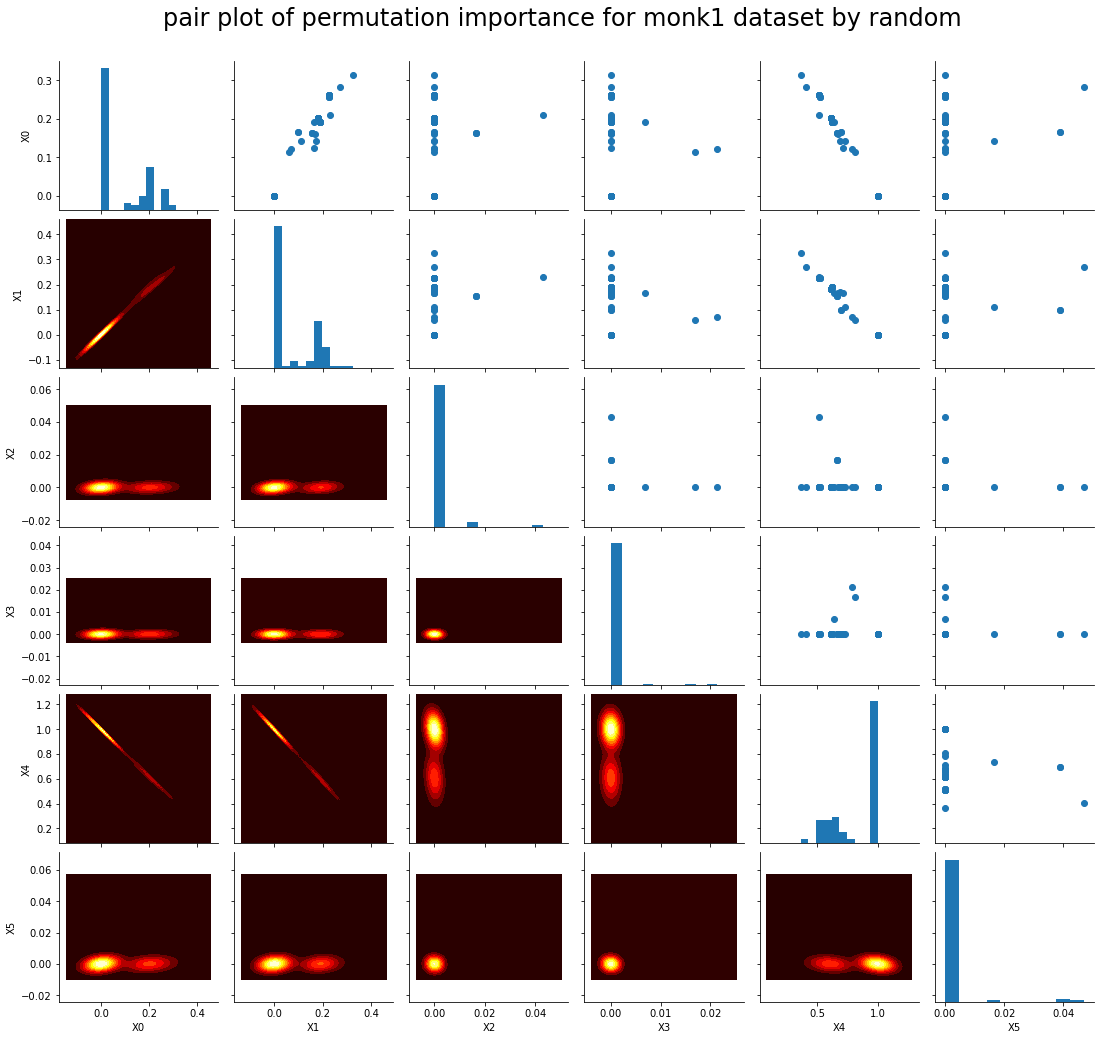

In [67]:
VIC_correlation(vic_list2, "permutation")

In [17]:
df = pd.DataFrame(vic_list)

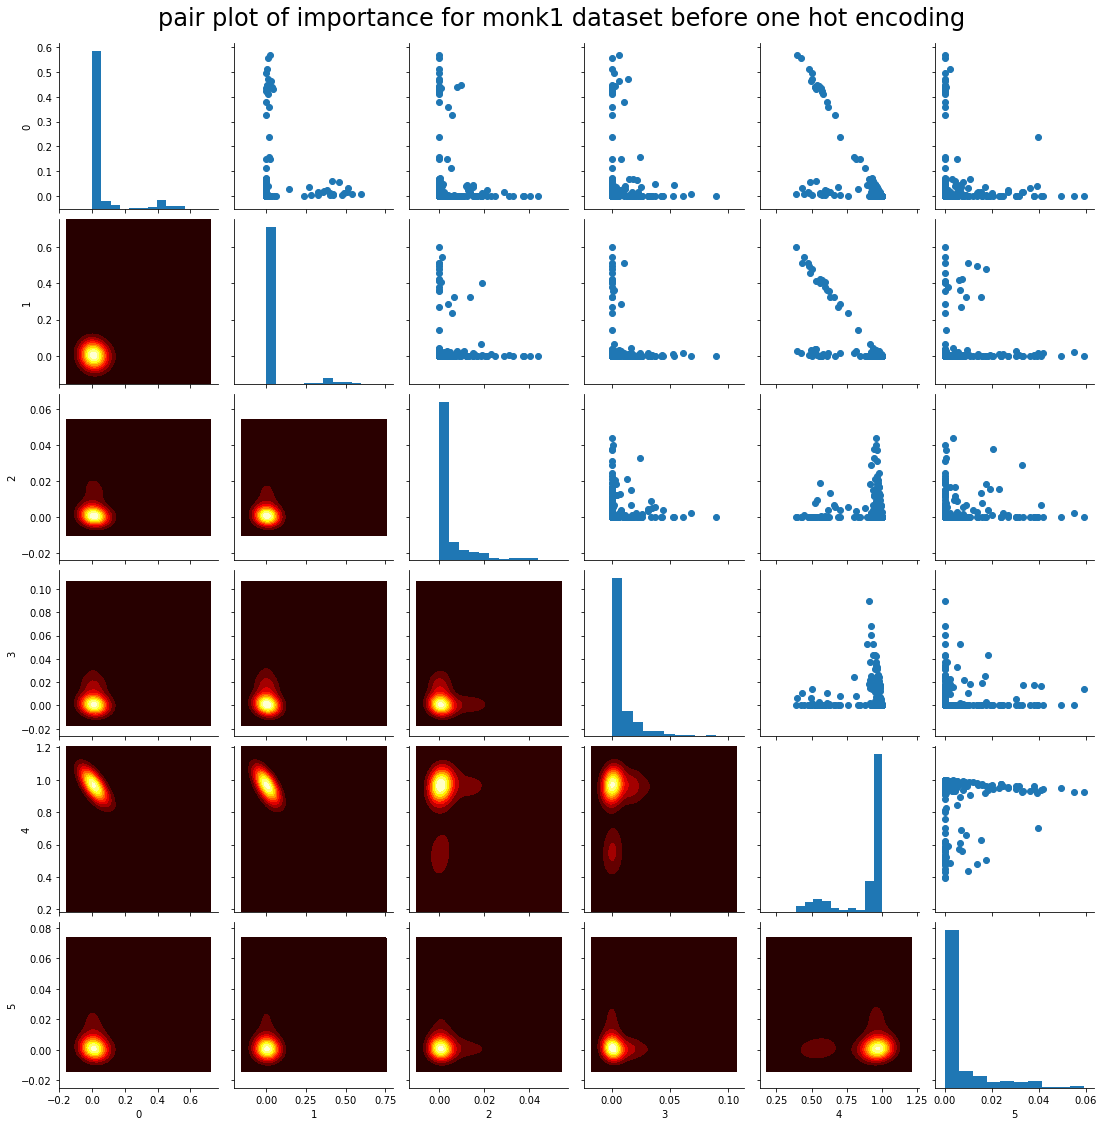

In [18]:
g = sns.pairplot(df)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap='hot', shade=True)
g = g.map_diag(plt.hist)
g = g.fig.suptitle("pair plot of importance for monk1 dataset before one hot encoding",
                   y=1.03, size=24)